In [ ]:
# ✅ Install required libraries (একবারই দাও)
!pip install -q torch transformers datasets accelerate scikit-learn
!pip install -q matplotlib seaborn numpy
!pip install --upgrade datasets
!pip install --upgrade transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 75.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 57.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 28.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 60.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 30.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import transformers
print(transformers.__version__)

4.52.4


In [ ]:
# ✅ Import necessary libraries
import pandas as pd
import numpy as np
import torch
import json
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer
from sklearn.metrics import classification_report, accuracy_score, precision_recall_fscore_support
from google.colab import files
import shutil
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
# ✅ Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
model_list = [
    "csebuetnlp/banglabert",
    "sagorsarker/bangla-bert-base",
    "Apucs/banglabert-finetuned-sc",
    "SarwarShafee/BanglaBert_with_TFModel",
    "csebuetnlp/banglabert_large",
    "csebuetnlp/banglabert_small"   # replace this here instead of arnob11792 model
]


In [ ]:
# ✅ SELECT MODEL FOR THIS NOTEBOOK → change index 0,1,2... per notebook
model_name = model_list[1]  # Example → for first notebook


In [ ]:
# ✅ Set save path in Drive
import os

save_folder = f"/content/drive/MyDrive/MultiBanFake/BanglaBert/{model_name.split('/')[-1]}"
os.makedirs(save_folder, exist_ok=True)

In [ ]:
# ✅ Load CSVs from Drive (NO MANUAL UPLOAD)
base_path = "/content/drive/MyDrive/MultiBanFake/Dataset/text"

train_df = pd.read_csv(f"{base_path}/Train.csv")
val_df = pd.read_csv(f"{base_path}/Validation.csv")
test_df = pd.read_csv(f"{base_path}/Test.csv")

# ✅ Check Columns of Train, Validation, Test DataFrames
print("📊 Train Columns:", train_df.columns.tolist())
print("📊 Validation Columns:", val_df.columns.tolist())
print("📊 Test Columns:", test_df.columns.tolist())

# ✅ Check Sample Rows
print("\n🔍 Sample Train Data:")
print(train_df.head())
print("\n🔍 Sample Validation Data:")
print(val_df.head())
print("\n🔍 Sample Test Data:")
print(test_df.head())

📊 Train Columns: ['image_id', 'headline', 'description', 'category', 'types of fake news', 'label']
📊 Validation Columns: ['image_id', 'headline', 'description', 'category', 'types of fake news', 'label']
📊 Test Columns: ['image_id', 'headline', 'description', 'category', 'types of fake news', 'label']

🔍 Sample Train Data:
               image_id                                           headline  \
0  entertainment_real_1           মুক্তি পেতেই ঝড় তুললো ‘জওয়ান’র নতুন গান!   
1  entertainment_real_2               নতুন এক সিনেমায় চুক্তিবদ্ধ হলেন দীঘি   
2  entertainment_real_3  এবার মায়ের সঙ্গে শুটিংয়ে যাচ্ছে পদ্ম, ভিডিও ভা...   
3  entertainment_real_4     পরিচালক থেকে এবার অভিনেতা মোস্তফা সরয়ার ফারুকী   
4  entertainment_real_5  কলকাতার সায়ন্তিকাকে নিয়ে কক্সবাজারে উড়াল দিলেন...   

                                         description       category  \
0  এবার প্রকাশ্যে এলো শাহরুখের ‘জওয়ান’র ছবিটির তৃ...  entertainment   
1  ইতোমধ্যে বেশ কয়েকটি সিনেমা এবং ওয়েবসিরিজে কাজ ...  entertain

In [ ]:
# ✅ Combine headline + description into 'text' column
for df in [train_df, val_df, test_df]:
    df["text"] = df["headline"].fillna('') + " " + df["description"].fillna('')

train_df = train_df[["text", "label"]]
val_df = val_df[["text", "label"]]
test_df = test_df[["text", "label"]]

In [ ]:
# ✅ Ensure label column is integer
train_df["label"] = train_df["label"].astype(int)
val_df["label"] = val_df["label"].astype(int)
test_df["label"] = test_df["label"].astype(int)

<ipython-input-10-3f38ff725bc8>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["label"] = test_df["label"].astype(int)


In [ ]:
# ✅ Convert to Hugging Face DatasetDict
dataset = DatasetDict({
    "train": Dataset.from_pandas(train_df),
    "validation": Dataset.from_pandas(val_df),
    "test": Dataset.from_pandas(test_df)
})

In [ ]:
# ✅ Load BanglaBERT tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

# ✅ Tokenization function
def tokenize_function(example):
    tokenized_review = tokenizer(example["text"], padding="max_length", truncation=True, max_length=256)
    tokenized_review["labels"] = example["label"]
    return tokenized_review

# ✅ Tokenize the dataset
tokenized_datasets = dataset.map(tokenize_function, batched=True)
tokenized_datasets = tokenized_datasets.remove_columns(["text"])
tokenized_datasets.set_format("torch")
print("✅ Sample tokenized review:", tokenized_datasets["train"][0])


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/491 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/2.24M [00:00<?, ?B/s]

Map:   0%|          | 0/7680 [00:00<?, ? examples/s]

Map:   0%|          | 0/960 [00:00<?, ? examples/s]

Map:   0%|          | 0/960 [00:00<?, ? examples/s]

✅ Sample tokenized review: {'label': tensor(0), 'input_ids': tensor([  101, 31465,  6399, 29061, 19151,  3447, 14973,  5602,  2395,  1560,
         7360,  2058, 19264,  1561,  2313, 20670,  2392,  2552,   999,  2318,
         2076, 27551,  8844,  4297,  2395, 11967, 37001,  1560,  7360,  2058,
        19264,  1561,  2313,  6438,  5279,  2765,  9294,  2552,  1560, 13012,
        24413,  2062,  7724,  2773, 41121, 11253,  7724,  1561,  1014, 11967,
        37001,  1560,  7360,  2058, 19264,  1561,  2313, 31465, 17471,  4856,
         3447, 73835, 33323,  2058,  2823,  2128,  2070,   999,  2174,  2200,
         2395,  4972, 18152,  2062,  2930,  2392, 19191,  3888,  2076, 27551,
         8844,  2870, 20670,  2392,  2285,  5803,  2044,  2285,  5803,  7430,
          999,  2109,  3110, 12351, 20547,  5128,  1007,   100,  5387, 55969,
         1008, 77928,  2046,  1022,  2551,  4026,  5063,  2099,  1012,  4163,
         7838, 10273, 19264, 37578, 50082,  7777,  1011,  6355,  2038,  8435,
   

In [ ]:
# ✅ Load BanglaBERT Model for Classification
model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=2)

# ✅ Print model label mapping
print("Model label2id mapping:", model.config.label2id)
print("Model id2label mapping:", model.config.id2label)


model.safetensors:   0%|          | 0.00/660M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at sagorsarker/bangla-bert-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Model label2id mapping: {'LABEL_0': 0, 'LABEL_1': 1}
Model id2label mapping: {0: 'LABEL_0', 1: 'LABEL_1'}


In [ ]:
# ✅ Define training arguments (Optimized for Colab Free)
training_args = TrainingArguments(
    output_dir="./results",
    save_strategy="epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    gradient_accumulation_steps=4,
    num_train_epochs=3,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    fp16=True,
)

In [ ]:
# ✅ Initialize Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    tokenizer=tokenizer,
)

<ipython-input-15-c37ec1eb58db>:2: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [ ]:
# ✅ Train the model,15a26bfde02e39ba547185222150f57c5c5d8e02

print("🚀 Training Started...")
trainer.train()
print("✅ Training Completed!")

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


🚀 Training Started...


wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: zarin-cse-20210104111 (zarin-cse-20210104111-ahsanullah-university-of-science-t) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
10,0.730800
20,0.731200
30,0.665400
40,0.705000
50,0.625000
60,0.662000
70,0.702900
80,0.601900
90,0.650900
100,0.628500


✅ Training Completed!


In [ ]:
# ✅ Evaluate model
predictions, labels, _ = trainer.predict(tokenized_datasets["test"])
predicted_classes = np.argmax(predictions, axis=-1)
labels = labels.astype(int)


In [ ]:
# ✅ Debug: Class distribution
unique, counts = np.unique(predicted_classes, return_counts=True)
print("🔍 Predicted Class Distribution:", dict(zip(unique, counts)))

# ✅ Classification report
print("📊 Fake vs Non-Fake Class Report:")
print(classification_report(labels, predicted_classes, target_names=["Fake", "Non-Fake"], digits=4))

# ✅ Compute and save metrics
accuracy = accuracy_score(labels, predicted_classes)
precision, recall, f1, _ = precision_recall_fscore_support(labels, predicted_classes, average=None)

results = {
    "Accuracy": accuracy,
    "Fake F1-score": f1[0],
    "Non-Fake F1-score": f1[1],
    "Weighted F1-score": precision_recall_fscore_support(labels, predicted_classes, average="weighted")[2]
}


🔍 Predicted Class Distribution: {0: 532, 1: 428}
📊 Fake vs Non-Fake Class Report:
              precision    recall  f1-score   support

        Fake     0.7331    0.8125    0.7708       480
    Non-Fake     0.7897    0.7042    0.7445       480

    accuracy                         0.7583       960
   macro avg     0.7614    0.7583    0.7576       960
weighted avg     0.7614    0.7583    0.7576       960



In [ ]:
# ✅ Save model and tokenizer to Drive
trainer.save_model(f"{save_folder}/FinalModel")
tokenizer.save_pretrained(f"{save_folder}/FinalModel")

# ✅ Save evaluation results to Drive
with open(f"{save_folder}/evaluation_results.json", "w") as f:
    json.dump(results, f)

In [ ]:
# ✅ Save softmax for stacking ensemble
def save_softmax(ds, name):
    raw_preds = trainer.predict(ds)
    probs = torch.nn.functional.softmax(torch.tensor(raw_preds.predictions), dim=-1).numpy()
    np.save(f"{save_folder}/{name}_softmax.npy", probs)
    return probs

save_softmax(tokenized_datasets["train"], "train")
save_softmax(tokenized_datasets["validation"], "val")
save_softmax(tokenized_datasets["test"], "test")


array([[9.7706646e-01, 2.2933565e-02],
       [9.7637820e-01, 2.3621807e-02],
       [9.9629277e-01, 3.7072529e-03],
       ...,
       [1.5397267e-03, 9.9846029e-01],
       [1.3198635e-03, 9.9868017e-01],
       [5.5711175e-04, 9.9944288e-01]], dtype=float32)

<ipython-input-21-c06eed30580b>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=train_counts.index, y=train_counts.values, ax=axes[0], palette=["red", "green"])
<ipython-input-21-c06eed30580b>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=val_counts.index, y=val_counts.values, ax=axes[1], palette=["red", "green"])
<ipython-input-21-c06eed30580b>:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=test_counts.index, y=test_counts.values, ax=axes[2], palette=["red", "green"])


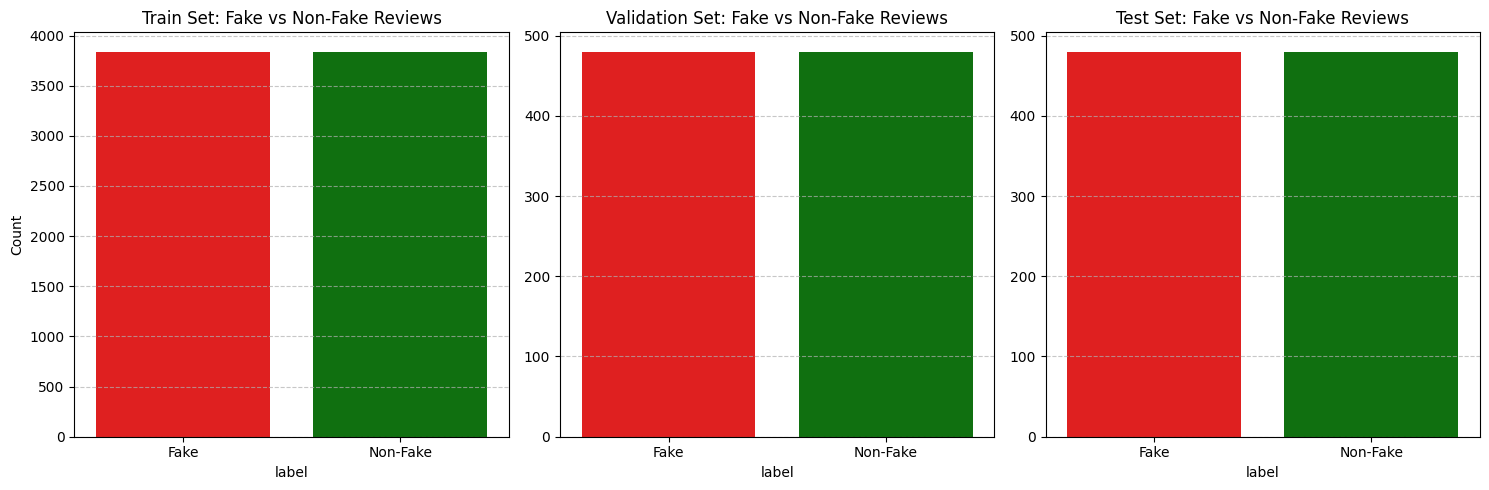

In [ ]:
# ✅ Visualize Dataset Distribution
train_counts = train_df["label"].value_counts().sort_index()
val_counts = val_df["label"].value_counts().sort_index()
test_counts = test_df["label"].value_counts().sort_index()

label_map = {0: "Fake", 1: "Non-Fake"}
train_counts.index = train_counts.index.map(label_map)
val_counts.index = val_counts.index.map(label_map)
test_counts.index = test_counts.index.map(label_map)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
sns.barplot(x=train_counts.index, y=train_counts.values, ax=axes[0], palette=["red", "green"])
axes[0].set_title("Train Set: Fake vs Non-Fake Reviews")
axes[0].set_ylabel("Count")
axes[0].grid(axis="y", linestyle="--", alpha=0.7)

sns.barplot(x=val_counts.index, y=val_counts.values, ax=axes[1], palette=["red", "green"])
axes[1].set_title("Validation Set: Fake vs Non-Fake Reviews")
axes[1].grid(axis="y", linestyle="--", alpha=0.7)

sns.barplot(x=test_counts.index, y=test_counts.values, ax=axes[2], palette=["red", "green"])
axes[2].set_title("Test Set: Fake vs Non-Fake Reviews")
axes[2].grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()
